# [Demo] Bayesian filters: follow rotations

Wouter Kouw | Last update: 17-08-2023
 

## System

Consider a discrete-time dynamical system with noisy observations $y_k \in \mathbb{R}^{d_y}$ and latent states $x_k \in \mathbb{R}^{d_x}$. We can express the dynamics in the form of a state-space model:

$$\begin{align}
x_k =&\ Ax_{k-1} + q_{k-1} \\
y_k =&\ Cx_k + r_{k} \, ,
\end{align}$$

where $A$ is a state transition matrix, $C$ is an observation emission matrix, $q_{k-1}$ represents process noise and $r_{k}$ is measurement noise. Both sources of noise are Gaussian distributed with zero mean:

$$q_{k-1} \sim \mathcal{N}(0, I) \, , \qquad r_k \sim \mathcal{N}(0, R) \, ,$$

with covariance matrices $I$ and $R$.

The state transition has the following form:

$$\begin{align*}
\underbrace{\begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix}}_{x_k} = \underbrace{\begin{bmatrix} \cos(\omega) & -\sin(\omega) & 0 & 0 \\ \sin(\omega) & \cos(\omega) & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0\end{bmatrix}}_{A} \underbrace{\begin{bmatrix} x_{1,k-1} \\ x_{2,k-1} \\ x_{3,k-1} \\ x_{4,k-1} \end{bmatrix}}_{x_{k-1}} + q_{k-1}
\end{align*}$$

where $\omega$ represents the angle.

The measurement function is described as:

$$\begin{align*}
\underbrace{\begin{bmatrix} y_{1,k} \\ y_{2,k} \\ y_{3,k} \\ y_{4,k} \end{bmatrix}}_{y_k} = \underbrace{\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}}_{C} \begin{bmatrix} x_{1,k} \\ x_{2,k} \\ x_{3,k} \\ x_{4,k} \end{bmatrix} + r_k
\end{align*}$$

The observations are noisy representations of the four latent states.

In [1]:
using LinearAlgebra
using Distributions
using ProgressMeter
using Plots
default(label="", grid=false, margin=20Plots.pt)

In [145]:
# Length of time-series
T = 300
Δt = 1.0

# Dimensionalities
D = 4

# Transition matrix
ω = 0.3
A = [cos(ω) -sin(ω)   0    0;
     sin(ω)  cos(ω)   0    0;
       0       0    .95  .08;
       0       0    .05  .96]

# Process noise covariance matrix
Q = diagm(ones(D))

# Emission matrix
C = diagm(ones(D));
    
# Measurement noise covariance matrix
σ = 0.1
R = σ^2 .*diagm(ones(D))
     
# Initial states
state_0 = randn(D)

# Initialize data array
states = zeros(D,T)
observations = zeros(D,T)

# Initialize previous state variable
prev_state = state_0

for k = 1:T
    
  # State transition
  states[:,k] = A*prev_state# + cholesky(Q).L*randn(D)

  # Observation with added measurement noise
  observations[:,k] = C*states[:,k] + cholesky(R).L*randn(D)

  # Update "previous state"
  prev_state = states[:,k]
  
end

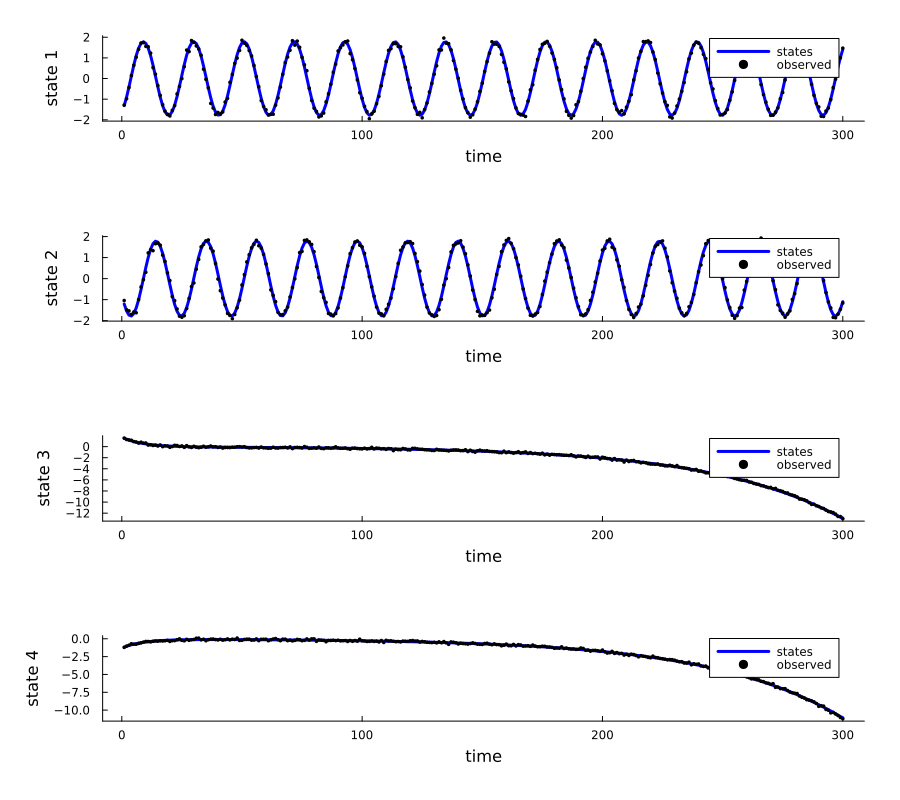

In [146]:
plts = []
for d = 1:D
    plt_d = plot(states[d,:], linewidth=3, color="blue", xlabel="time", ylabel="state $d", label="states", size=(700,400))
    scatter!(observations[d,:], color="black", markersize=2, label="observed")

    push!(plts, plt_d)
end
plot(plts..., layout=(D,1), size=(900,D*200))

## Model

We will apply a model where both the states and the transition matrix $A$ are unknown. Consider the probabilistic state-space model:

$$\begin{align}
p(x_k | x_{k-1}, A) &= \mathcal{N}(x_k | Ax_{k-1}, Q) \\
p(y_k | x_k) &= \mathcal{N}(y_k | Cx_{k-1}, R) \, .
\end{align}$$

We will have a prior distribution on the states

$$p(x_0) = \mathcal{N}(x_0 | m_0, P_0) \, ,$$

as well as a prior distribution on the rows of the transition matrix

$$p(A | \gamma) = \prod_{d=1}^{D} \mathcal{N}(A_d | 0, \gamma_d^{-1}I) \, .$$

This prior is centered on $0$ with a precision parameter $\gamma_d$ that determines how much a particular element in this row can deviate from $0$. It has its own prior distribution in the form:

$$p(\gamma_d) = \mathcal{G}(\gamma_d | \alpha_d, \beta_d) \, ,$$

with shape parameters $\alpha$ and rate parameters $\beta$.

In [147]:
include("../variational_filters.jl")

AX_filter2 (generic function with 1 method)

In [148]:
# Relevance prior
α0 = [1.0, 1.0, 0.1, 0.1]
β0 = [1.0, 1.0, 1.0, 1.0]
pγ0 = [Gamma(α0[d], β0[d]) for d in 1:D]

# State prior
m0 = zeros(D)
S0 = 1e-3diagm(ones(D))
px0 = MvNormal(m0,S0)

# Variational filter
mx,Sx,Cx, M,U, α,β = AX_filter([observations[:,k] for k in 1:T], Q, C, R, pγ0, px0, num_iters=10);

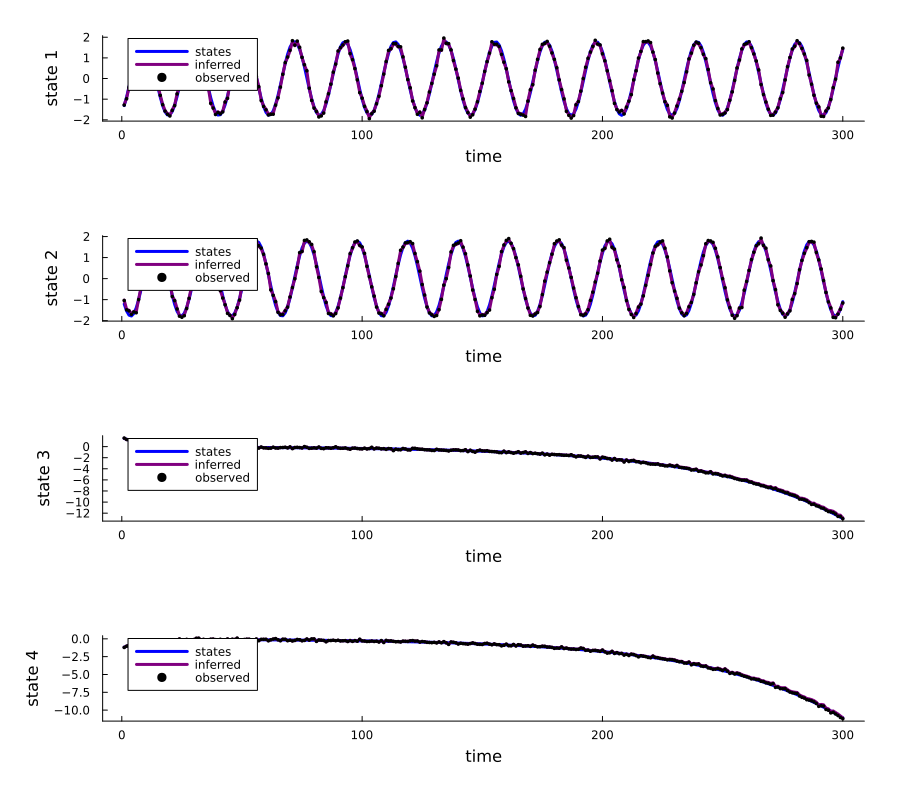

In [149]:
plts = []
for d = 1:D
    plt_d = plot(size=(700,400),legend=:topleft)
    plot!(states[d,:], linewidth=3, color="blue", xlabel="time", ylabel="state $d", label="states")
    plot!(mx[d,:], ribbon=Sx[d,d,:], linewidth=3, color="purple", label="inferred")
    scatter!(observations[d,:], color="black", markersize=2, label="observed")

    push!(plts, plt_d)
end
plot(plts..., layout=(D,1), size=(900,D*200))

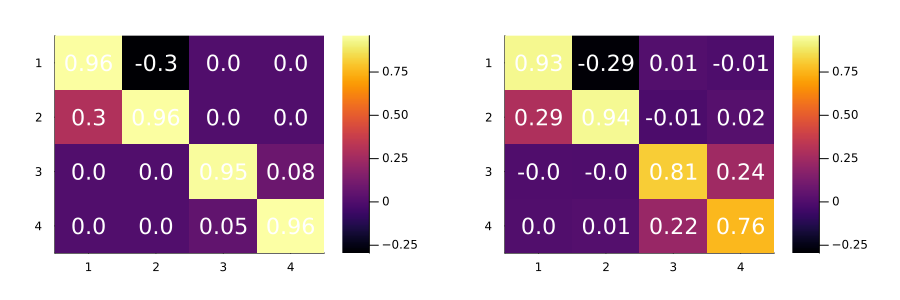

In [150]:
cmins = minimum([minimum(A[:]), minimum(M[:])])
cmaxs = maximum([maximum(A[:]), maximum(M[:])])

fontsize=15

# Plot inferred state transition matrix
p21 = heatmap(A, yflip=true, clims=(cmins,cmaxs))
ann = [(i,j, text(round(A[j,i], digits=2), fontsize, :white, :center)) for i in 1:D for j in 1:D]
annotate!(ann, linecolor=:white)

p22 = heatmap(M, yflip=true, clims=(cmins,cmaxs))
ann = [(i,j, text(round(M[j,i], digits=2), fontsize, :white, :center)) for i in 1:D for j in 1:D]
annotate!(ann, linecolor=:white)

plot(p21,p22, layout=(1,2), size=(900,300))